In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-page-session-data/web_page_data.csv


# Permutation test

In a permutation procedure, two or more samples are involved, typically the groups
in an A/B or other hypothesis test. Permute means to change the order of a set of val‐
ues. The first step in a permutation test of a hypothesis is to combine the results from
groups A and B (and, if used, C, D,…). This is the logical embodiment of the null
hypothesis that the treatments to which the groups were exposed do not differ. We
then test that hypothesis by randomly drawing groups from this combined set and
seeing how much they differ from one another. 

The permutation procedure is as
follows:
1. Combine the results from the different groups into a single data set.
2. Shuffle the combined data and then randomly draw (without replacement) a
resample of the same size as group A (clearly it will contain some data from the
other groups).
3. From the remaining data, randomly draw (without replacement) a resample of
the same size as group B.
4. Do the same for groups C, D, and so on. You have now collected one set of
resamples that mirror the sizes of the original samples.
5. Whatever statistic or estimate was calculated for the original samples (e.g., differ‐
ence in group proportions), calculate it now for the resamples, and record; this
constitutes one permutation iteration.
6. Repeat the previous steps R times to yield a permutation distribution of the test
statistic.

Now go back to the observed difference between groups and compare it to the set of
permuted differences. If the observed difference lies well within the set of permuted
differences, then we have not proven anything—the observed difference is within the
range of what chance might produce. However, if the observed difference lies outside
most of the permutation distribution, then we conclude that chance is not responsi‐
ble. In technical terms, the difference is statistically significant. 

# Web stickiness 

A company selling a relatively high-value service wants to test which of two web pre‐
sentations does a better selling job. One potential proxy variable for the company is the number of clicks on the detailed landing page. A better one is how long people spend on the page. It is reasonable to think that a web presentation (page) that holds people’s attention longer will lead to more sales. Hence, our metric is average session time, comparing page A to page B.

In [4]:
session_times = pd.read_csv("/kaggle/input/web-page-session-data/web_page_data.csv")

In [5]:
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [6]:
session_times.Time = 100*session_times.Time

In [7]:
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [9]:
session_times.describe()

,Time
count,36.000000
mean,141.194444
std,94.240670
min,21.000000
25%,70.250000
50%,118.000000
75%,199.250000
max,357.000000


In [18]:
session_times['Page'].value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

**There are 21 entries for Page A and 15 for Page B**

In [19]:
import matplotlib.pyplot as plt 

<AxesSubplot: title={'center': 'Time'}, xlabel='Page'>

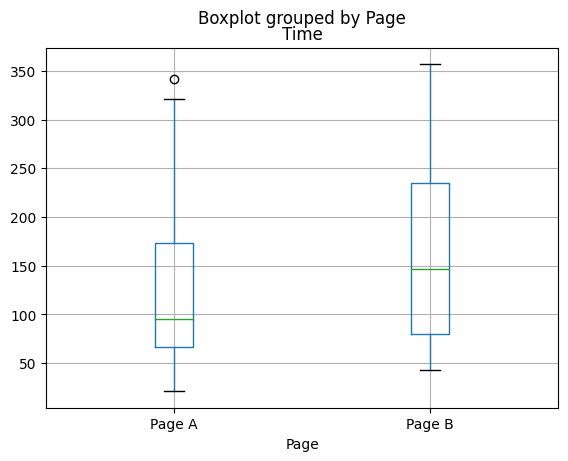

In [20]:
session_times.boxplot(by='Page',column='Time')

This indicates that page B leads to longer sessions than
page A.

## Observed mean

Let's compute the observed means for page A & B

In [22]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_a

126.33333333333333

In [23]:
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b

162.0

In [44]:
mean_b - mean_a

35.66666666666667

Page B has session times that are greater than those of page A by 35.67 seconds, on
average. The question is whether this difference is within the range of what random
chance might produce, i.e., is statistically significant. One way to answer this is to
apply a permutation test—combine all the session times together and then repeatedly
shuffle and divide them into groups of 21 (recall that nA
= 21 for page A) and 15
(nB= 15 for page B).

# Permutation test

In [31]:
import random

In [25]:
# Permutation test example 

def permutation_test(x,nA,nB):
    
    # Combining group A and B 
    n = nA + nB
    
    # Setting index for B (ie) Choosing nB random elements from n no's
    idx_b = set(random.sample(range(n),nB))
    
    # Setting index for A by removing the B index 
    idx_a = set(range(n)) - idx_b 
    
    # Returning the difference of mean B and mean A 
    return x.loc[list(idx_b)].mean() - x.loc[list(idx_a)].mean()

In [28]:
nA = session_times[session_times['Page'] == 'Page A'].shape[0]
nA

21

In [29]:
nB = session_times[session_times['Page'] == 'Page B'].shape[0]
nB

15

In [34]:
print(permutation_test(session_times.Time,nA,nB))

68.92380952380952


Similarly we can do this n no of times to get the distribution of the differences

This function works by sampling (without replacement) nB indices and assigning
them to the B group; the remaining nA indices are assigned to group A. The differ‐
ence between the two means is returned. Calling this function R = 1,000 times and
specifying nA
= 21 and nB= 15 leads to a distribution of differences in the session
times that can be plotted as a histogram. I

In [41]:
random.seed(1)

perm_diffs = [permutation_test(session_times.Time,nA,nB) for i in range(1000)]


In [42]:
perm_diffs[0:5]

[6.523809523809518,
 -17.59047619047618,
 22.866666666666674,
 -6.161904761904765,
 10.29523809523809]

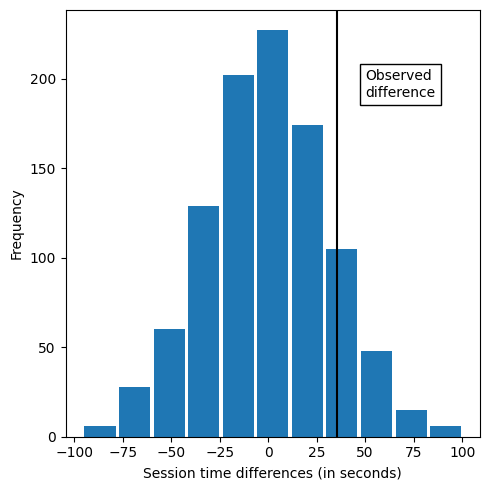

In [48]:
fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs,bins=11,rwidth = 0.9)
ax.axvline(x = mean_b - mean_a,color = 'black')
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
ax.text(50,190,'Observed\ndifference',bbox={'facecolor':'white'})

plt.tight_layout()
plt.show()

In [50]:
perm_diffs = np.array(perm_diffs)

In [57]:
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


The histogram shows that mean difference of random permutations
often exceeds the observed difference in session times (the vertical line). For our
results, this happens in 12.1% of the cases. As the simulation uses random numbers, the percentage will vary

**This suggests that the observed difference in session time between page A and page B
is well within the range of chance variation and thus is not statistically significant.**